# Смирнов Сергей Артёмович, ФПэ-01-22

### Задача 1
Оценить расходы в цилиндр высокого давления и в конденсатор турбины без промежуточного переграва пара.

Заданные параметры:
* Номинальная электрическая мощность: 250 МВт
* Начальное давление свежего пара: 23.5 МПа
* Начальная температура свежено пара: 540 C
* Конечное давление пара: 6.9 кПа
* Температура питательной воды:  263 C
* Число отборов: 8
* Механическое КПД: 99.2%
* КПД Электрогенератора: 99%

In [5]:
import iapws
from iapws import IAPWS97 as SteamProperties

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa  
convert_to_kelvin = lambda temp_celsius: temp_celsius + 273.15 if temp_celsius is not None else None

# Исходные данные
electrical_power_watts = 250 * (10 ** 6)  
high_pressure = 23.5 * MPa       
high_temperature_celsius = 540          
condenser_pressure = 6.9 * kPa  
feedwater_temperature_celsius = 263      
mechanical_efficiency = 0.992            
generator_efficiency = 0.99        

# Расчет параметров для состояния в главных точках
state_1 = SteamProperties(P=high_pressure * unit, T=convert_to_kelvin(high_temperature_celsius))
state_2 = SteamProperties(P=condenser_pressure * unit, s=state_1.s) 
state_2_saturated = SteamProperties(P=condenser_pressure * unit, x=0)  
enthalpy_1 = state_1.h  
enthalpy_2 = state_2.h  
enthalpy_2_saturated = state_2_saturated.h  
enthalpy_3 = enthalpy_2_saturated + high_pressure * unit  

# Расчет термодинамической эффективности
efficiency_numerator = (enthalpy_1 - enthalpy_3) - (enthalpy_2 - enthalpy_2_saturated)
efficiency_denominator = enthalpy_1 - enthalpy_3
cycle_efficiency = efficiency_numerator / efficiency_denominator

# Расчет полезного теплоперепада
useful_heat_drop = cycle_efficiency * (enthalpy_1 - enthalpy_2)

# Расчет массовых расходов
turbine_inlet_mass_flow = electrical_power_watts / (
    useful_heat_drop * 1000 * mechanical_efficiency * generator_efficiency
)

condenser_mass_flow = (
    electrical_power_watts /
    ((enthalpy_2 - enthalpy_2_saturated) * 1000 * mechanical_efficiency * generator_efficiency) *
    ((1 / cycle_efficiency) - 1)
)

print("Массовый расход в турбину на входе (кг/с):", turbine_inlet_mass_flow)
print("Массовый расход в конденсатор (кг/с):", condenser_mass_flow)


Массовый расход в турбину на входе (кг/с): 411.1407614021325
Массовый расход в конденсатор (кг/с): 184.14074729744


### Задача 2
Написать автоматизированный поиск коэффициента с оси Y по данному значению оси Х для линии 7 в случае присутствия пром. перегрева (график с пары). Вывести полученный график коэффициентов.

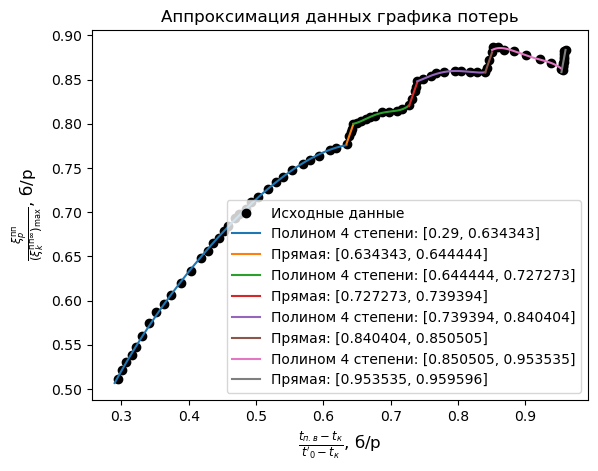

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data = np.loadtxt('fithe_data.txt', dtype=float, delimiter=';', comments=None)


def polynomial_4(x, a, b, c, d, e):#, e
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def linear(x, m, c):
    return m * x + c

def piecewise_fit(data, intervals):
    x = data[:, 0]
    y = data[:, 1]
    
    results = []
    for interval, func in intervals:
        mask = (x >= interval[0]) & (x <= interval[1])
        x_interval = x[mask]
        y_interval = y[mask]
        
        if func == "polynomial_4":
            params, _ = curve_fit(polynomial_4, x_interval, y_interval)
            results.append((interval, polynomial_4, params))
        elif func == "linear":
            params, _ = curve_fit(linear, x_interval, y_interval)
            results.append((interval, linear, params))
            # print(interval)
    return results

intervals = [
    ([0.29,0.634343], "polynomial_4"),
    ([0.634343,0.644444], "linear"),
    ([0.644444,0.727273], "polynomial_4"),
    ([0.727273,0.739394], "linear"),
    ([0.739394,0.840404], "polynomial_4"),
    ([0.840404,0.850505], "linear"),
    ([0.850505,0.953535], "polynomial_4"),
    ([0.953535,0.959596], "linear")
]

results = piecewise_fit(data, intervals)

plt.scatter(data[:, 0], data[:, 1], label="Исходные данные", color="black")
for interval, func, params in results:
    x_fit = np.linspace(interval[0], interval[1], 10000)
    if func == polynomial_4:
        y_fit = polynomial_4(x_fit, *params)
        label = f"Полином 4 степени: {interval}"
    elif func == linear:
        y_fit = linear(x_fit, *params)
        label = f"Прямая: {interval}"
    plt.plot(x_fit, y_fit, label=label)

plt.legend()

plt.xlabel(r"$\frac{t_{п.в} - t_{к}}{t'_0 - t_{к}}$, б/р", fontsize=12)
plt.ylabel(r"$\frac{\xi^{\text{пп}}_p}{(\xi^{\text{пп} \infty}_k)_{\text{max}}}$, б/р", fontsize=12)

plt.title("Аппроксимация данных графика потерь")
plt.show()
